In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
from metal.analysis import confusion_matrix
from metal.utils import convert_labels
from tagger import Tagger
import spacy

nlp = spacy.load("en_core_web_sm")

### Load Data

In [2]:
task_name = 'RTE'
split = 'dev'
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/{task_name}_{split}_error_analysis.tsv'
df_error = load_dataframe(filepath)

### View Errors

Plotting probabilities from the first column of Y_probs


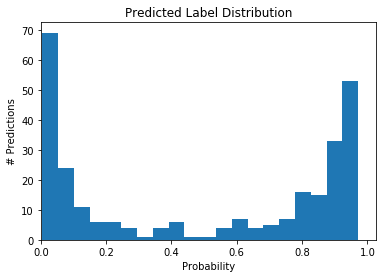

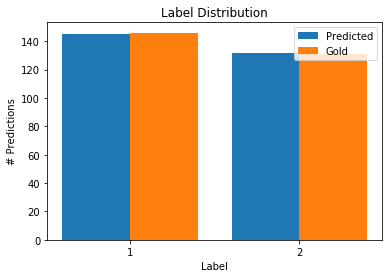

Plotting probabilities from the first column of Y_probs


/dfs/scratch0/mccreery/repos/metal/metal/contrib/visualization/analysis.py:147: RuntimeWarning: invalid value encountered in long_scalars
  bin_accuracy = sum(bin_idxs * correct_idxs) / sum(bin_idxs)


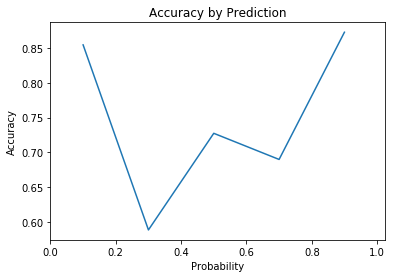

In [3]:
Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Predicted Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Accuracy by Prediction", bins=5)

In [4]:
# print("\033[1mBARELY RIGHT\033[0;0m")
# print_barely_right(df_error, thresh=0.4, n=10)
# print("\033[1mBARELY WRONG\033[0;0m")
# print_barely_wrong(df_error, thresh=0.2, n=1)
# print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.5, n=40)

49 matches were found with the given criteria.

sentence1: 	 Mi ##ce given a substance found in red wine lived longer despite a fatty diet , a study shows . 
sentence2: 	 Mi ##ce fed with red wine lived longer despite a fatty diet . 
score: 	0.9307
label: 	2

sentence1: 	 Monica Meadows , a 22 - year - old model from Atlanta , was shot in the shoulder on a subway car in New York City . 
sentence2: 	 Monica Meadows , 23 , was shot in shoulder while riding a subway car in New York City 
score: 	0.8319
label: 	2

sentence1: 	 The letter received by Syracuse TV station News 10 Now is still being analyzed , but police believe it was written by 41 - year - old Ji ##ver ##ly Wong , police chief Joseph Z ##ik ##usk ##i said at a brief ##ing . " We have no reason to believe it ' s not ( authentic ) , " Z ##ik ##usk ##i said . " It ' s another piece of evidence in a very complex puzzle that ' s going to take us weeks and months to determine what ' s going on . It ' s going to help us . " In the 

In [5]:
i = np.random.randint(df_error.shape[0])
row = df_error.iloc[i]
print('sentence 1: ', row.sentence1.replace(" ##", ""))
print('sentence 2: ', str(row.sentence2).replace(" ##", ""))
print()
print('label: ', row.label)
print('score: ', row.score)

sentence 1:   Kevin Whitaker , who heads the Cuban affairs office at the Department of State , spoke with Lazo on two occasions about the effort to give his sons visas . 
sentence 2:   Kevin Whitaker is a manager of the Department of State . 

label:  1
score:  0.8375998735427856


In [23]:
# tagger = Tagger(tags_dir='slices')
# tagger.get_examples('SST2_dev_while')

# Slicing

In [6]:
model_path = ''
task_name = 'RTE'
split = 'dev'
# multi task
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/{task_name}_{split}_error_analysis.tsv'
# single task
# filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)
df_error = load_dataframe(filepath)
df_error.head()

/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_16_19/RTE_dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,pred,is_wrong
0,0,"Dana Reeve , the widow of the actor Christoph...",Christopher Reeve had an accident .,0.008222,2,2,False
1,1,"Yet , we now are discovering that anti ##biot...",Ba ##cter ##ia is winning the war against ant...,0.084538,1,2,True
2,2,Cairo is now home to some 15 million people -...,15 million tonnes of rub ##bish are produced ...,0.124581,2,2,False
3,3,"The Am ##ish community in Pennsylvania , whic...",Pennsylvania has the biggest Am ##ish communi...,0.007069,2,2,False
4,4,Security forces were on high alert after an e...,Security forces were on high alert after a ca...,0.917214,1,1,False


In [7]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
from nltk.translate.bleu_score import sentence_bleu

In [6]:
from slicing import *

df = df_error[['sentence1','sentence2']].apply(slice_morepeople, axis=1)

in_slice = df_error[df]
wrong_in_slice = in_slice[in_slice.is_wrong]
wrong_in_slice.head()

,Unnamed: 0,sentence1,sentence2,score,label,pred,is_wrong
110,110,Ren and St ##im ##py . Bugs Bunny . Philip J ...,Bugs Bunny is owned by Warner Bros .,0.118893,1,2,True
195,195,"The mistaken spelling , Miller explained , wa...",Judith Miller works for the New York Times .,0.095334,1,2,True
207,207,""" Be ##a Arthur and I first met when we did '...",The actress Angela La ##ns ##bury is 86 years...,0.830601,2,1,True
267,267,The letter received by Syracuse TV station Ne...,Ji ##ver ##ly Won was a police chief .,0.812876,2,1,True


In [54]:
from slicing import *
    
df = df_error[['sentence1','sentence2']].apply(slice_who, axis=1)

in_slice = df_error[df]
print(in_slice.head())

from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE {} DATASET'.format(task_name))

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

   Unnamed: 0                                          sentence1  \
1           1   What is the first major city in the stream of...   
2           2   What is the minimum required if you want to t...   
3           3   How was Te ##m ##ü ##jin kept imprisoned by t...   
4           4   What did Herr Got ##t , di ##ch lobe ##n w ##...   
5           5   What year did the the case go before the supr...   

                                           sentence2     score  label  pred  \
1   The most important tributaries in this area a...  0.715851      2     1   
2   In most provinces a second Bachelor ' s Degre...  0.872881      2     1   
3   The Ta ##yi ##chi ' u ##d enslaved Te ##m ##ü...  0.866531      1     1   
4   He para ##ph ##rase ##d the Te De ##um as " H...  0.011868      2     2   
5   For example , Joseph Haas was arrested for al...  0.001374      2     2   

   is_wrong  
1      True  
2      True  
3     False  
4     False  
5     False  
IN ENTIRE QNLI DATASET
Accuracy:

In [12]:
# filename = f'slices/{task_name}_{split}_qualifiers.txt'
# print(in_slice)
# in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.